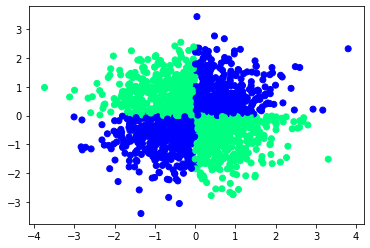

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt as co
co.solvers.options['show_progress'] = False

def get_next_train_valid(X_shuffled, y_shuffled, itr, k):
    """
    - itr value can tell you which fold you pick up for valid and rest go to training
    - use 1 fold for validation and all other folds for training
    - in next iteration, use a different fold for validation and remaining folds for training
        
    Basically, here you will determine which fold goes for validation and which ones for training
    """
    X_valid = X_shuffled[itr*len(X_shuffled)//k:(itr+1)*len(X_shuffled)//k,:]
    Y_valid = y_shuffled[itr*len(y_shuffled)//k:(itr+1)*len(y_shuffled)//k]
    
    X_train = np.delete(X_shuffled, np.s_[itr*len(X_shuffled)//k:(itr+1)*len(X_shuffled)//k:1], 0)
    Y_train = np.delete(y_shuffled, np.s_[itr*len(y_shuffled)//k:(itr+1)*len(y_shuffled)//k:1], 0)
    
    
    return  X_train, Y_train, X_valid, Y_valid

def train(X_train, y_train, C):
    P = np.zeros((len(X_train),len(X_train)))
    for i in range(len(X_train)):
        for j in range(len(X_train)):
            P[i,j] = y_train[i]*y_train[j]* np.exp(-1/2*np.linalg.norm(X_train[i]-X_train[j])**2)
    P = co.matrix(P, tc= 'd')
    q = -co.matrix(np.ones(len(X_train)), tc = 'd')
    G = co.matrix(np.concatenate((np.identity(len(X_train)),-np.identity(len(X_train)))),tc = 'd')
    h = co.matrix(np.concatenate((C*np.ones(len(X_train)),np.zeros(len(X_train)))), tc = 'd')
    sol = co.solvers.qp(P,q,G,h)
    lambda_sol = sol['x']
#    w_sol = np.dot(R,lambda_sol)
 #   print(P*lambda_sol)
    return lambda_sol

def predict(X_valid, X_train, y_train, lambda_sol ):
    a = np.zeros(len(X_valid))
    for i in range(len(X_valid)):
        for j in range(len(X_train)):
            a[i] = a[i] + np.exp(-1/2*np.linalg.norm(X_valid[i] - X_train[j])**2)*lambda_sol[j]*y_train[j]
    return np.sign(a)


data = pd.read_csv("hw2data.csv", header = None)
samples = np.array(data)


np.random.shuffle(samples)

test_sample = samples[:len(samples)//5]
train_sample = samples[len(samples)//5:]


X_shuffled = train_sample[:,:-1]
y_shuffled = train_sample[:,-1]
X_test = test_sample[:,:-1]
y_test = test_sample[:,-1]
plt.scatter(X_shuffled[:,0],X_shuffled[:,1],c= y_shuffled ,cmap='winter')
plt.show()


In [6]:
k = 10

C_set =  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

acc_valid = np.zeros(k)
acc_train = np.zeros(k)

avg_acc_valid =np.zeros(len(C_set))
avg_acc_train =np.zeros(len(C_set))
acc_test = np.zeros(len(C_set))
W = np.zeros(2)
for j in range(len(C_set)):
        for i in range(k):
            
            X_train, y_train, X_valid, y_valid = get_next_train_valid(X_shuffled, y_shuffled, i , k)
            
            W = train(X_train, y_train, C_set[j])
            
            y_predict_train = predict(X_train, X_train, y_train, W)
            y_predict = predict(X_valid, X_train, y_train, W)
            y_predict_train = np.reshape(y_predict_train,len(X_train))
            y_predict = np.reshape(y_predict,len(X_valid))

            acc_train[i] = np.sum(y_train == y_predict_train)/len(X_train)
            acc_valid[i] = np.sum(y_valid == y_predict)/len(X_valid)
            
        avg_acc_valid[j] = np.mean(acc_valid)
        avg_acc_train[j] = np.mean(acc_train)
        
        #train on full training set
        W = train(X_shuffled, y_shuffled, C_set[j])
        y_test_train = predict(X_test, X_train, y_train, W)
        y_test_train = np.reshape(y_test_train,len(X_test))
        acc_test[j] = np.sum(y_test_train == y_test)/len(X_test)

print(avg_acc_valid)
print(avg_acc_train)
print(acc_test)

plt.xlabel('C')
plt.ylabel('Accurate Rate')
plt.plot(C_set,  avg_acc_valid, 'r.',label = 'Average accuracy rate of validation')   
plt.plot(C_set,  avg_acc_train, 'b.',label = 'Average accuracy rate of training')  
plt.plot(C_set, acc_test, 'g.', label = 'Accuracy rate of testing')
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.xlabel('C')
plt.ylabel('Accurate Rate')
plt.plot(np.log10(C_set),  avg_acc_valid, 'r-',label = 'Average accuracy rate of validation')   
plt.plot(np.log10(C_set),  avg_acc_train, 'b-',label = 'Average accuracy rate of training')  
plt.plot(np.log10(C_set), acc_test, 'g-', label = 'Accuracy rate of testing')
plt.legend()